In [ ]:
import thicket as th
from glob import glob

files = glob("group-cali-files/**/*.cali")
data = th.Thicket.from_caliperreader(files)

(2/2) Creating Thicket: 100%|██████████| 1077/1077 [00:17<00:00, 60.27it/s]


## Strong Scaling Speedup

In [88]:
def plot_speedup(x, ys, leg_labels, title, sort_level, figname):
    _, ax = plt.subplots()
    ax.plot(x, ys[0], 'x--', label=leg_labels[0], markersize=10)
    ax.plot(x, ys[1], '.--', label=leg_labels[1])
    ax.plot(x, ys[2], 'o--', label=leg_labels[2], fillstyle='none')
    # ax.plot(x, ys[3], 'p--', label=leg_labels[3], fillstyle='none')
    ax.set_xscale('log', base=2)
    ax.set_xlabel(f"Number of Processes (log 2 scaled)")
    ax.set_ylabel("Speedup Factor")
    ax.set_title(f"{title} Speedup Factor Strong Scaling (Sort Level={sort_level})")
    ax.legend()
    # plt.savefig(f"plots/strong-speedup/{figname}.png", dpi=600, bbox_inches="tight")
    plt.show()

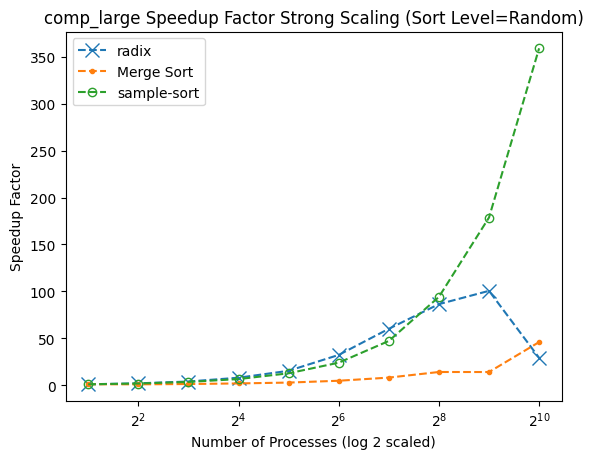

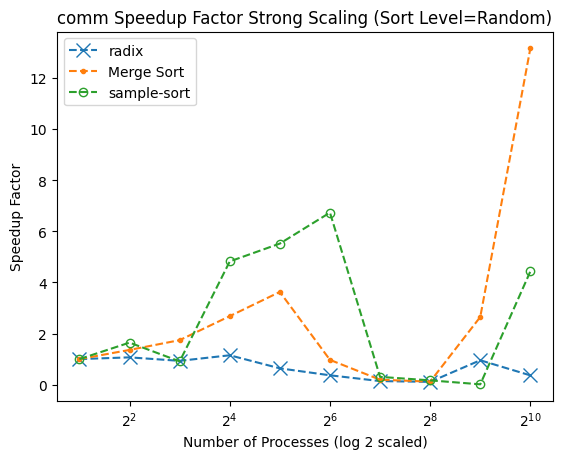

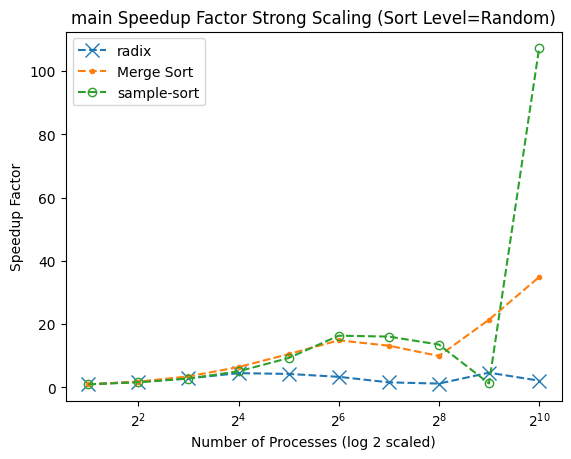

In [81]:
for node in node_strings:
    y_scaling = []
    for sort, times in ys_time[node].items():
        runtimes = times
        speedup = [runtimes[0]/x for x in runtimes]
        y_scaling.append(speedup)
    plot_speedup(num_procs, y_scaling, leg_labels, node, "Random", None)

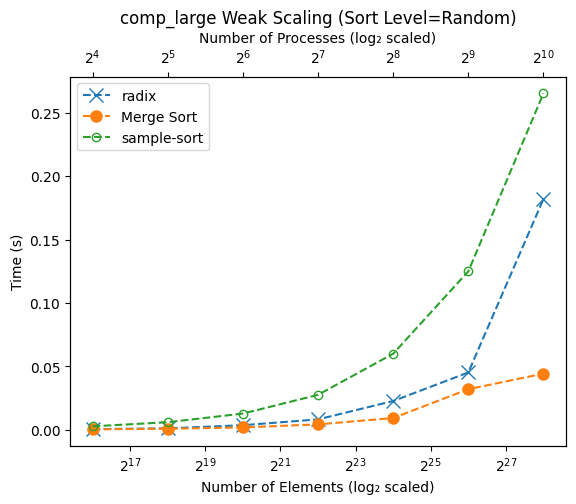

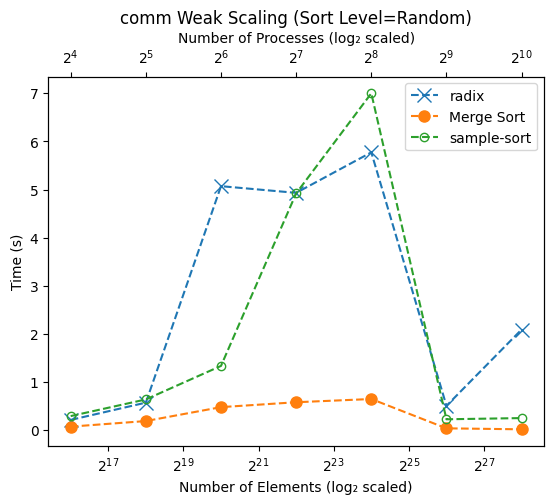

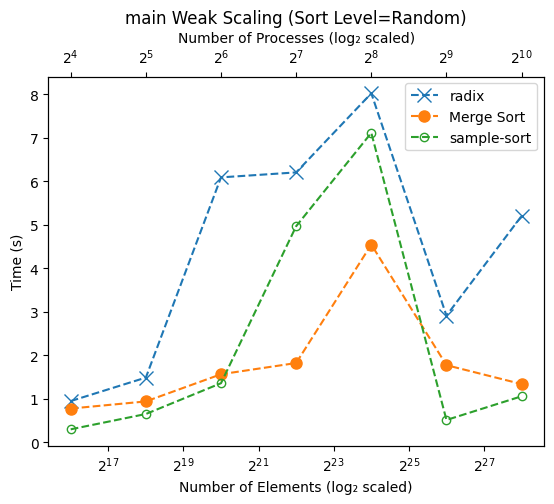

In [93]:
import matplotlib.pyplot as plt

df = data.dataframe
df = df[df["Avg time/rank"].isna() == False]
data.dataframe = df


def plot_runtimes_weak(x_proc, x_elem, ys, labels, title, sort_level, figname):
    """
    Plots weak scaling for two algorithms.

    Parameters:
    - x_proc: list of number of processes
    - x_elem: list of total number of elements
    - ys: list of two y-values lists [algo1_avg, algo2_avg]
    - labels: list of two algorithm names
    - title: region/node title
    - sort_level: e.g., 'Random'
    - figname: filename (unused if just showing)
    """
    _, ax = plt.subplots()
    ax2 = ax.twiny()

    # Plot two lines for the two algorithms
    ax.plot(x_elem, ys[0], 'x--', label=labels[0], markersize=10)
    ax.plot(x_elem, ys[1], 'o--', label=labels[1], markersize=8)
    ax.plot(x_elem, ys[2], 'o--', label=labels[2], fillstyle='none')
    # Add invisible lines to link processes on top axis
    ax2.plot(x_proc, ys[0], alpha=0)
    ax2.plot(x_proc, ys[1], alpha=0)
    ax2.plot(x_proc, ys[2], alpha=0)

    # Set log scales
    ax.set_xscale('log', base=2)
    ax2.set_xscale('log', base=2)

    # Labels
    ax.set_xlabel("Number of Elements (log₂ scaled)")
    ax2.set_xlabel("Number of Processes (log₂ scaled)")
    ax.set_ylabel("Time (s)")
    ax.set_title(f"{title} Weak Scaling (Sort Level={sort_level})")
    ax.legend()
    plt.show()



import numpy as np
from itertools import product
from copy import deepcopy
int_to_string = {
    0: "Sorted",
    1: "Perturbed",
    2: "Random",
    3: "Reversed"
}
algorithms = {"radix": [], "Merge Sort": [], 'sample-sort': []}

sub_data = data.groupby(["input_size", "num_procs", "input_type", 'algorithm'])
allowed_procs = [16, 32, 64, 128, 256, 512, 1024]
allowed_elems = [2**x for x in (16, 18, 20, 22, 24, 26, 28)]
allowed_combs = list(zip(allowed_procs, allowed_elems))

levels = {"Random"}
ys = {node: {alg: {level: deepcopy(metrics) for level in levels} for alg in algorithms.keys()}
      for node in node_strings}

for cols, thic in sub_data.items():
   for node_string in node_strings:

      node = thic.get_node(node_string)
      sort_level = thic.dataframe.loc[node, "input_type"].values[0]
      algorithm = thic.dataframe.loc[node, "algorithm"].values[0]
      x_proc = int(thic.dataframe.loc[node, "num_procs"].values.flatten()[0])
      x_size = int(thic.dataframe.loc[node, "input_size"].values.flatten()[0])
      if sort_level == 'random':
         sort_level = 2
      if (((x_proc, x_size) not in allowed_combs) or sort_level != 2):
         continue
      sort_level = int_to_string[sort_level]

      y_avg = float(
          thic.dataframe.loc[node, "Avg time/rank"].values.flatten()[0])
      ys[node_string][algorithm][sort_level]["Avg"].append(y_avg)


# Plot loop
for node_string in node_strings:
    for level in levels:
        ys_to_plot = []
        labels = []

        for algorithm in algorithms.keys():
            y_avg = ys[node_string][algorithm][level]["Avg"]
            if not y_avg:
                continue

            # Pad to match allowed_elems length
            y_avg += [np.nan]*(len(allowed_elems) - len(y_avg))
            ys_to_plot.append(y_avg)
            labels.append(algorithm)

        if len(ys_to_plot) != 3:
            continue  # skip if we don't have both algorithms

        plot_runtimes_weak(
            allowed_procs,
            allowed_elems,
            ys_to_plot,
            labels,
            node_string,
            level,
            f"{node_string}-{level}-weak"
        )